In [2]:
#http://stackoverflow.com/questions/11845055/predicting-from-previous-datevalue-data
import matplotlib.pyplot as plt
import pandas as pd # v. 1.7
import MySQLdb
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import mean_absolute_error,mean_squared_error
import statistics 
%matplotlib inline 

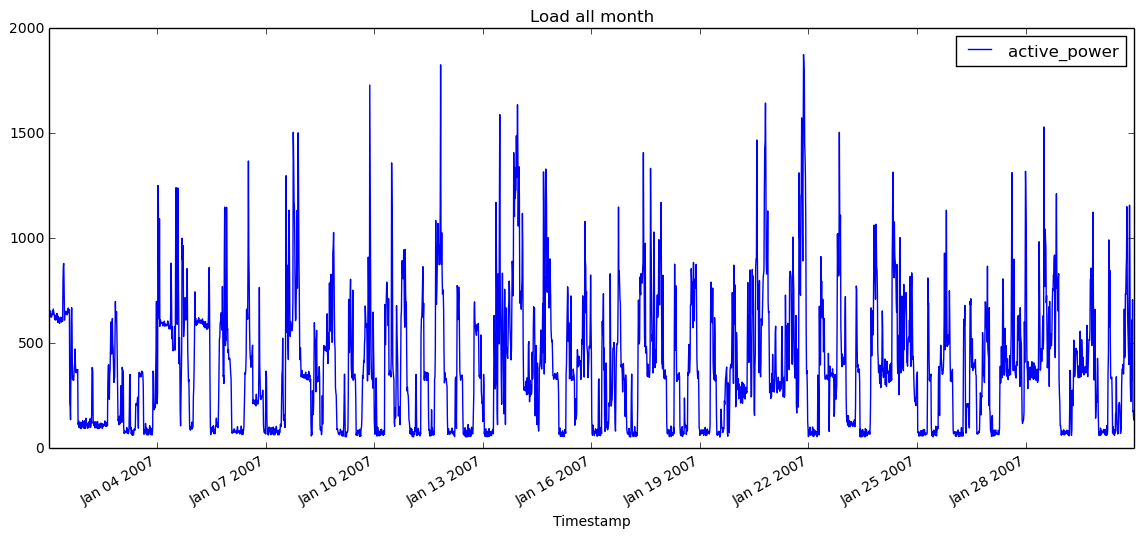

Size of Data:  2880  Day = 30


In [3]:
conn = MySQLdb.connect("localhost","conn","hems")
cursor = conn.cursor()

query = "SELECT Timestamp,active_power FROM prediction.data15min WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-01 00:14:59","2007-01-30 23:59:59")

df = pd.read_sql(query, conn , index_col=['Timestamp'])
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title('Load all month')
df.plot(ax=ax)
plt.show()


print "Size of Data: ", len(df) , " Day =", len(df)/96

In [5]:
import MySQLdb
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

# >>> initial_trend(series, 12)
# -0.7847222222222222

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# # forecast 24 points (i.e. two seasons)
# >>> triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)
# [30, 20.34449316666667, 28.410051892109554, 30.438122252647577, 39.466817731253066, ...


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


pred_no = 1 # power 1 Data/15min in 1Hr --> 60/15 = 4 and 1day = 4*24 = 96
##-----------------------------------------------------------------------------------
j = 0
i = 0
d = 14


conn = MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()

time_a = pd.date_range('2007-01-01 00:14:59', periods=d*96, freq='15T')
time_b = pd.date_range('2007-01-14 23:59:59', periods=(d*96)+1, freq='15T')


#df=df[df.EL!=0]

# set databases to empty 
query_empty = """truncate table prediction.Holtallsub_15T""" 
c.execute(query_empty)

print ""
while (j < 96*d ) :
    print "Days :" , j
    query = "SELECT Timestamp,watt_sumsub FROM prediction.Holtsumsub_15T WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% (time_a[0],time_b[j])
    df = pd.read_sql(query, conn, index_col=['Timestamp'])
    conn.commit()
    
    data_y = df['watt_sumsub'].values.tolist()
    #triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):  alpha=.8, beta=.5)
    pred_h = triple_exponential_smoothing(data_y, 96*7, 0.716, 0.01, 0.01, pred_no)
#     print len(data_y)    
    pred_data = pred_h[len(pred_h)-(pred_no):]
#     print "Days :" , j
#     print "len" , len(df) , i

#         print i ,
    c.execute("INSERT INTO prediction.Holtallsub_15T (Timestamp, watt) VALUES ( %s, %s)",(time_b[j+1],abs(pred_data[0])))
    conn.commit()
#         print '.',
    
    j += 1
print "DONE!!"





Days : 0


ZeroDivisionError: float division by zero

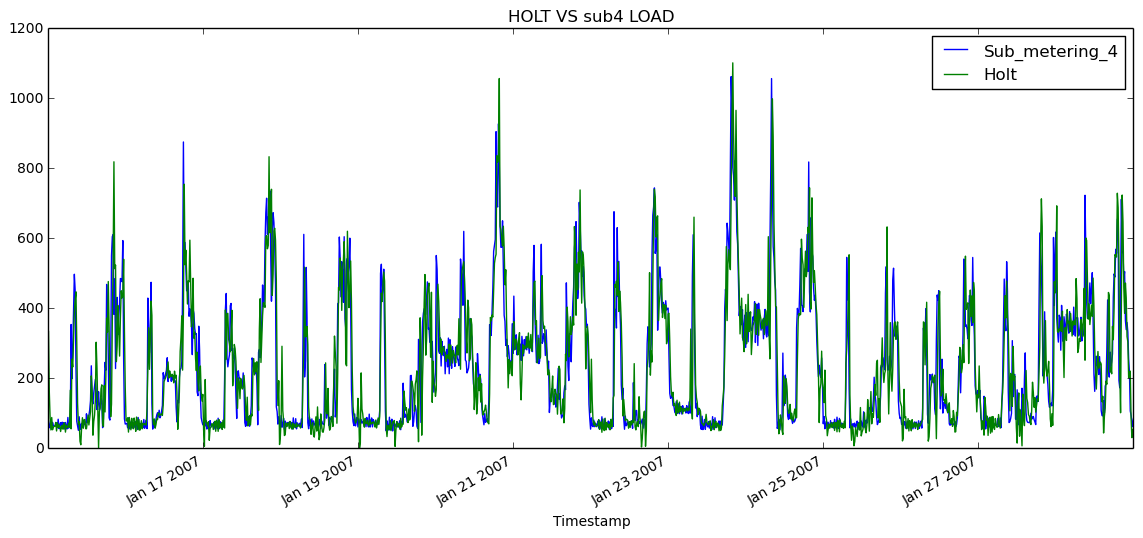

Size of Data_load:  1344  Day = 14
Size of Data_holr:  1344  Day = 14
9542.157523


In [4]:
from sklearn.metrics import mean_squared_error

conn = MySQLdb.connect("localhost","conn","hems")
cursor = conn.cursor()

query_holt = "SELECT * FROM prediction.Holtsub4_15T WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-15 00:00:00","2007-01-28 23:59:59")
query = "SELECT Timestamp, Sub_metering_4 FROM prediction.data15min WHERE Timestamp >= '%s'   AND TimeStamp <= '%s';"% ("2007-01-15 00:00:00","2007-01-28 23:59:59")
df_holt = pd.read_sql(query_holt, conn , index_col=['Timestamp'])
df = pd.read_sql(query, conn , index_col=['Timestamp'])

mse=mean_squared_error(df_holt.watt_sub4, df.Sub_metering_4)
# df.to_csv('out.csv')
# df_holt.to_csv('out1.csv')

df['Holt'] = df_holt.watt_sub4
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title('HOLT VS sub4 LOAD')
df.plot(ax=ax)
plt.show()


print "Size of Data_load: ", len(df) , " Day =", len(df)/96
print "Size of Data_holr: ", len(df_holt) , " Day =", len(df_holt)/96
print mse
